In [1]:
import market_abm
import json
import random
import matplotlib.pyplot as plt




In [2]:
NUM_BUYERS = 5000
NUM_SELLERS = 5
ROUNDS = 1000

T_GINI = 0.9
MEAN_INCOME = 1700
INIT_CASH_RESERVE = 1000

BANKRUPTCY_THRESHOLD = 3
LEARNING_RATE = 0.15
MIN_PRICE_MARKUP = 1.5

FIXED_OPERATING_COST_BASE = 5
OPERATING_COST_PER_ITEM = 0.5
MAX_INVENTORY_CAPACITY = 500

--- Round 1 ---
--- Round 2 ---
--- Round 3 ---
--- Round 4 ---
--- Round 5 ---
--- Round 6 ---
--- Round 7 ---
--- Round 8 ---
--- Round 9 ---
--- Round 10 ---
--- Round 11 ---
--- Round 12 ---
--- Round 13 ---
--- Round 14 ---
--- Round 15 ---
--- Round 16 ---
--- Round 17 ---
--- Round 18 ---
--- Round 19 ---
--- Round 20 ---
--- Round 21 ---
--- Round 22 ---
--- Round 23 ---
--- Round 24 ---
--- Round 25 ---
--- Round 26 ---
--- Round 27 ---
--- Round 28 ---
--- Round 29 ---
--- Round 30 ---
--- Round 31 ---
--- Round 32 ---
--- Round 33 ---
--- Round 34 ---
--- Round 35 ---
--- Round 36 ---
--- Round 37 ---
--- Round 38 ---
--- Round 39 ---
--- Round 40 ---
--- Round 41 ---
--- Round 42 ---
--- Round 43 ---
--- Round 44 ---
--- Round 45 ---
--- Round 46 ---
--- Round 47 ---
--- Round 48 ---
--- Round 49 ---
--- Round 50 ---
--- Round 51 ---
--- Round 52 ---
--- Round 53 ---
--- Round 54 ---
--- Round 55 ---
--- Round 56 ---
--- Round 57 ---
--- Round 58 ---
--- Round 59 ---
--- Ro

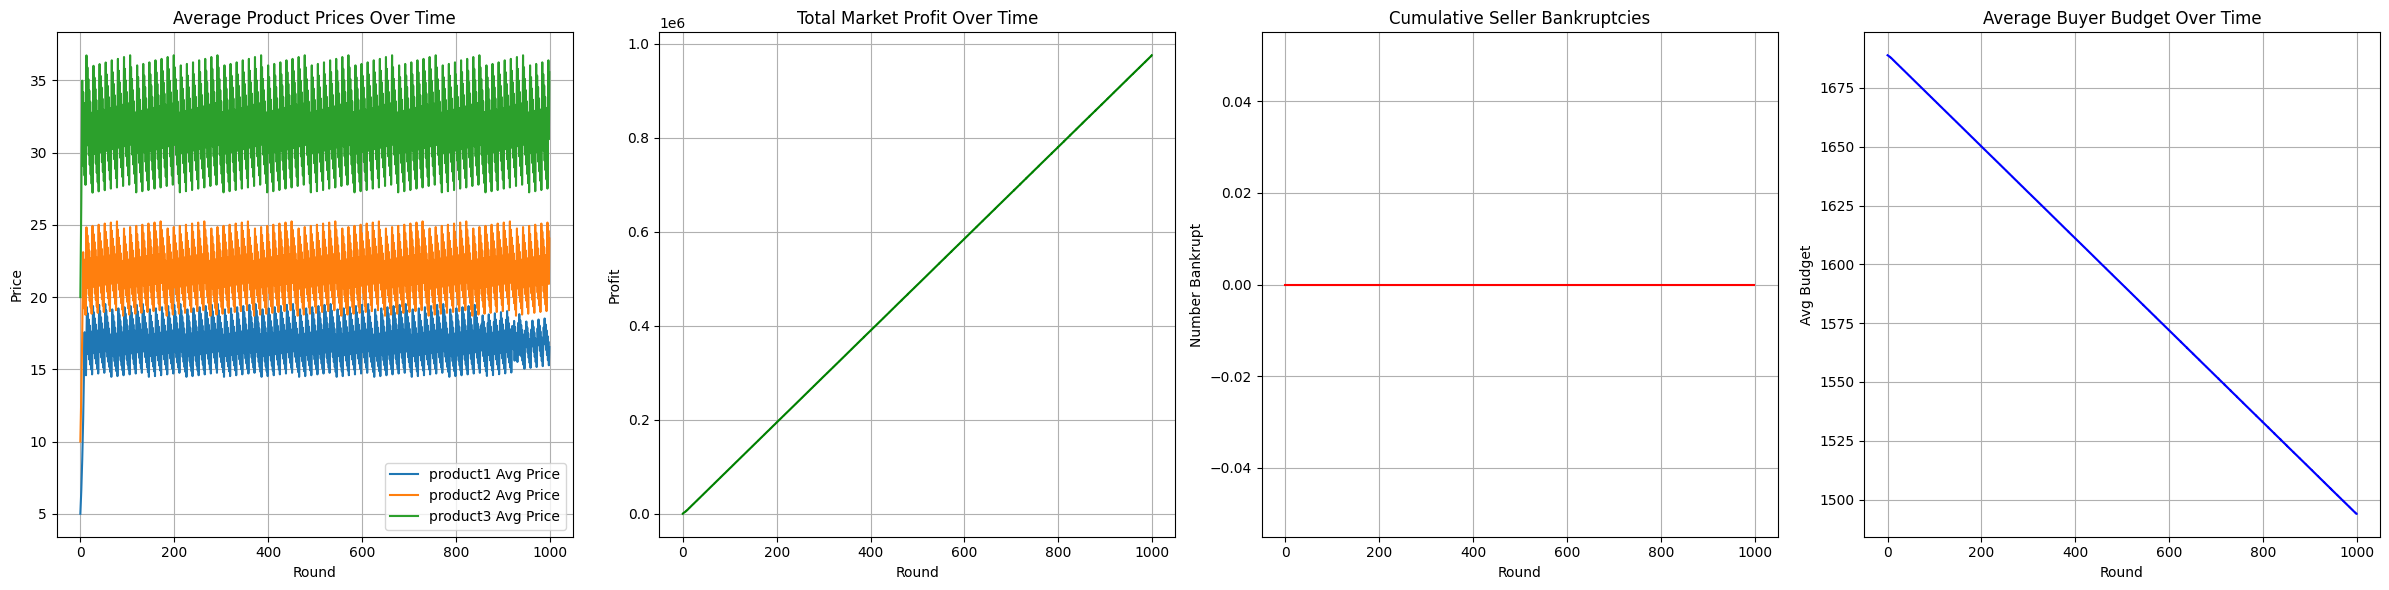

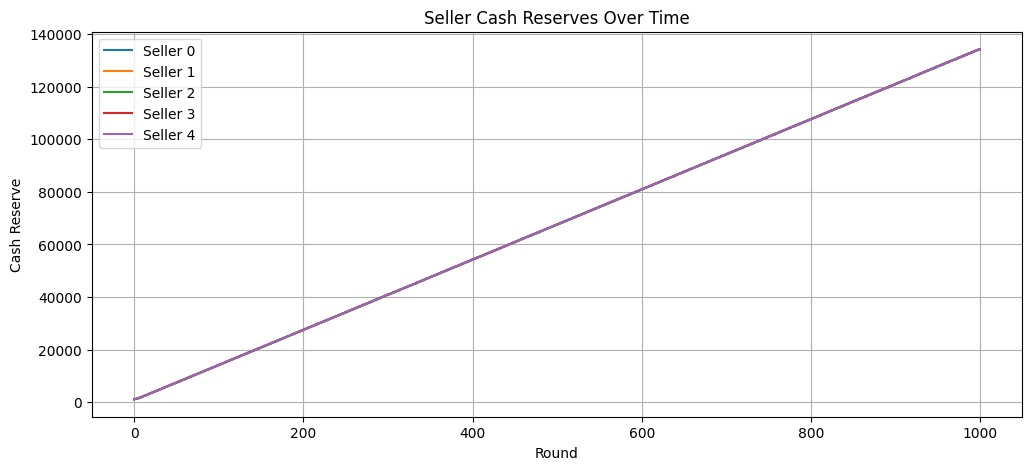

In [3]:


# ------------------------------
# 2. Utility Decay and Recovery Parameters
# ------------------------------
product_catalog = {
    'product1': {'base_price': 5, 'base_utility': 15, 'initial_inventory': 15},
    'product2': {'base_price': 10, 'base_utility': 20, 'initial_inventory': 10},
    'product3': {'base_price': 20, 'base_utility': 30, 'initial_inventory': 5},
}
product_ids = list(product_catalog.keys())

# Decay and recovery linked to price if desired
product_decay_params = {
    pid: {
        'decay_rate': max(0.03, 0.5 / product_catalog[pid]['base_price']),
        'randomness': 0.01 * product_catalog[pid]['base_price']
    } for pid in product_ids
}

product_recovery_params = {
    'product1': 0.05,
    'product2': 0.07,
    'product3': 0.03,
}


# ------------------------------
# 6. Simulation Setup
# ------------------------------

initial_incomes = market_abm.gen_income(T_GINI, MEAN_INCOME, NUM_BUYERS)

buyers = [market_abm.Buyer(
    id=i,
    budget=initial_incomes[i],
    product_ids=product_ids,
    product_catalog=product_catalog,
    product_decay_params=product_decay_params,
    product_recovery_params=product_recovery_params
) for i in range(NUM_BUYERS)]

sellers = [market_abm.Seller(
    id=i,
    products={pid: product_catalog[pid]['initial_inventory'] for pid in product_ids},
    supply_costs={pid: product_catalog[pid]['base_price'] * 0.5 for pid in product_ids},
    prices={pid: product_catalog[pid]['base_price'] for pid in product_ids},
    max_inventory_capacity = MAX_INVENTORY_CAPACITY,
    init_cash_reserve = INIT_CASH_RESERVE
) for i in range(NUM_SELLERS)]

# ------------------------------
# 7. Main Simulation Loop
# ------------------------------
market_history = []
bankrupt_counts = []
seller_reserves = []
avg_budgets_over_time = []


debug = False

for round_num in range(ROUNDS):
    print(f"--- Round {round_num + 1} ---")
    active_sellers = [s for s in sellers if s.active]
    if not active_sellers:
        print("All sellers bankrupt. Ending simulation.")
        break

    # For debugging purpose
    if debug == True:   
        for seller in active_sellers:
            print('try')
            print(seller.products.values())

    random.shuffle(buyers)
    for buyer in buyers:
        buyer.try_to_buy(active_sellers, product_ids)

    avg_budget = sum(b.budget for b in buyers) / len(buyers)
    avg_budgets_over_time.append(avg_budget)
    avg_prices = {
        pid: round(sum(s.get_price(pid) for s in active_sellers) / len(active_sellers), 2)
        for pid in product_ids
    }
    total_profit = sum(sum(s.total_profit.values()) for s in active_sellers)

    for seller in active_sellers:
        seller.calculate_profit(OPERATING_COST_PER_ITEM,FIXED_OPERATING_COST_BASE,BANKRUPTCY_THRESHOLD)
        seller.adjust_prices(MIN_PRICE_MARKUP,LEARNING_RATE)

        # For debugging purpose
        if debug == True:         
            print('re')
            print(seller.products.values())
            input("Press Enter to continue...")
        seller.restock()

    bankrupt_counts.append(len([s for s in sellers if not s.active]))
    seller_reserves.append([s.cash_reserve for s in sellers])
    market_history.append((round_num, avg_prices.copy(), total_profit))

# ------------------------------
# 8. Visualization
# ------------------------------
rounds_list, avg_price_list, total_profits = zip(*market_history)

plt.figure(figsize=(24, 6))

# Plot 1: Average Prices
plt.subplot(1, 4, 1)
for pid in product_ids:
    plt.plot(rounds_list, [p[pid] for p in avg_price_list], label=f"{pid} Avg Price")
plt.title("Average Product Prices Over Time")
plt.xlabel("Round")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

# Plot 2: Total Profit
plt.subplot(1, 4, 2)
plt.plot(rounds_list, total_profits, color='green')
plt.title("Total Market Profit Over Time")
plt.xlabel("Round")
plt.ylabel("Profit")
plt.grid(True)

# Plot 3: Bankruptcies
plt.subplot(1, 4, 3)
plt.plot(rounds_list, bankrupt_counts, color='red')
plt.title("Cumulative Seller Bankruptcies")
plt.xlabel("Round")
plt.ylabel("Number Bankrupt")
plt.grid(True)

# Plot 4: Average Budget
plt.subplot(1, 4, 4)
plt.plot(range(len(avg_budgets_over_time)), avg_budgets_over_time, color='blue')
plt.title("Average Buyer Budget Over Time")
plt.xlabel("Round")
plt.ylabel("Avg Budget")
plt.grid(True)

plt.tight_layout()
plt.show()

# Optional: Seller reserves
plt.figure(figsize=(12, 5))
for sid in range(NUM_SELLERS):
    plt.plot([res[sid] for res in seller_reserves], label=f"Seller {sid}")
plt.title("Seller Cash Reserves Over Time")
plt.xlabel("Round")
plt.ylabel("Cash Reserve")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
sellers